<h1>Classification</h1>

In [ ]:
import pandas as pd
import numpy as np
from textblob import TextBlob
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, words
from nltk.tokenize import word_tokenize
from timeit import default_timer as timer
import emoji
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import requests, json
from sklearn.utils import shuffle
import string
import html
import re
import pickle
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, classification_report
from sklearn.naive_bayes import ComplementNB
import tensorflow as tf

Come primo step, vado a scaricare i datasets necessari (tramite il comando *wget*), che contengono tweet classificati con 5 differenti tipi di emozioni:
* Anger (rabbia)
    - Training set $\rightarrow$ http://saifmohammad.com/WebDocs/EmoInt%20Train%20Data/anger-ratings-0to1.train.txt
    - Test set $\rightarrow$ http://saifmohammad.com/WebDocs/EmoInt%20Test%20Data/anger-ratings-0to1.test.target.txt
* Fear (paura)
    - Training set $\rightarrow$ http://saifmohammad.com/WebDocs/EmoInt%20Train%20Data/fear-ratings-0to1.train.txt
    - Test set $\rightarrow$ http://saifmohammad.com/WebDocs/EmoInt%20Test%20Data/fear-ratings-0to1.test.target.txt
* Joy (gioia)
    - Training set $\rightarrow$ http://saifmohammad.com/WebDocs/EmoInt%20Train%20Data/joy-ratings-0to1.train.txt
    - Test set $\rightarrow$ http://saifmohammad.com/WebDocs/EmoInt%20Test%20Data/joy-ratings-0to1.test.target.txt
* Sadness (tristezza)
    - Training set $\rightarrow$ http://saifmohammad.com/WebDocs/EmoInt%20Train%20Data/sadness-ratings-0to1.train.txt
    - Test set $\rightarrow$ http://saifmohammad.com/WebDocs/EmoInt%20Test%20Data/sadness-ratings-0to1.test.target.txt


Ogni file viene rinominato con il rispettivo sentiment.





In [ ]:
%%bash
wget -O anger.csv http://saifmohammad.com/WebDocs/EmoInt%20Train%20Data/anger-ratings-0to1.train.txt
wget -O fear.csv http://saifmohammad.com/WebDocs/EmoInt%20Train%20Data/fear-ratings-0to1.train.txt
wget -O joy.csv http://saifmohammad.com/WebDocs/EmoInt%20Train%20Data/joy-ratings-0to1.train.txt
wget -O sadness.csv http://saifmohammad.com/WebDocs/EmoInt%20Train%20Data/sadness-ratings-0to1.train.txt


wget -O anger2.csv http://saifmohammad.com/WebDocs/EmoInt%20Test%20Data/anger-ratings-0to1.test.target.txt
wget -O fear2.csv http://saifmohammad.com/WebDocs/EmoInt%20Test%20Data/fear-ratings-0to1.test.target.txt
wget -O joy2.csv http://saifmohammad.com/WebDocs/EmoInt%20Test%20Data/joy-ratings-0to1.test.target.txt
wget -O sadness2.csv http://saifmohammad.com/WebDocs/EmoInt%20Test%20Data/sadness-ratings-0to1.test.target.txt

--2021-06-09 16:22:24--  http://saifmohammad.com/WebDocs/EmoInt%20Train%20Data/anger-ratings-0to1.train.txt
Resolving saifmohammad.com (saifmohammad.com)... 192.185.17.122
Connecting to saifmohammad.com (saifmohammad.com)|192.185.17.122|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 95686 (93K) [text/plain]
Saving to: â€˜anger.csvâ€™

     0K .......... .......... .......... .......... .......... 53%  118K 0s
    50K .......... .......... .......... .......... ...       100%  284K=0.6s

2021-06-09 16:22:25 (162 KB/s) - â€˜anger.csvâ€™ saved [95686/95686]

--2021-06-09 16:22:26--  http://saifmohammad.com/WebDocs/EmoInt%20Train%20Data/fear-ratings-0to1.train.txt
Resolving saifmohammad.com (saifmohammad.com)... 192.185.17.122
Connecting to saifmohammad.com (saifmohammad.com)|192.185.17.122|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133186 (130K) [text/plain]
Saving to: â€˜fear.csvâ€™

     0K .......... .......... .......... ........

Oltre ad utilizzare i 4 dataset precedenti, vado ad utilizzare anche il dataset "*text_emotion*" presente in __[questo link](https://data.world/crowdflower/sentiment-analysis-in-text#)__. <br>
Vado quindi a leggere i datasets con l'opportuno carattere separatore ed *encoding*

In [ ]:
anger1 = pd.read_csv('anger.csv',sep='\t',header=None,encoding='utf-8')
fear1 = pd.read_csv('fear.csv',sep='\t',header=None,encoding='utf-8')
joy1 = pd.read_csv('joy.csv',sep='\t',header=None,encoding='utf-8')
sadness1 = pd.read_csv('sadness.csv',sep='\t',header=None,encoding='utf-8')


anger2 = pd.read_csv('anger2.csv',sep='\t',header=None,encoding='utf-8')
fear2 = pd.read_csv('fear2.csv',sep='\t',header=None,encoding='utf-8')
joy2 = pd.read_csv('joy2.csv',sep='\t',header=None,encoding='utf-8')
sadness2 = pd.read_csv('sadness2.csv',sep='\t',header=None,encoding='utf-8')

# https://data.world/crowdflower/sentiment-analysis-in-text#
text_emotion = pd.read_csv('text_emotion.csv',encoding='utf-8')

Anche se i dataset sono già suddivisi in *training set* e *test set*, per rendere il tutto più uniforme, vado ad combinarli, in modo da ottenere un dataset unico per ciascun sentiment: questa operazione viene effettuata tramite la funzione *concat* di Pandas

In [ ]:
anger = pd.concat([anger1,anger2])
fear = pd.concat([fear1,fear2])
joy = pd.concat([joy1,joy2])
sadness = pd.concat([sadness1,sadness2])

A partire dai 4 dataset, tramite *concat* li unisco, rinomino le colonne e seleziono solamente quelle che mi servono, ovvero il tweet vero e proprio e il sentiment; dopodichè effettuo un mapping sentiment-intero

In [ ]:
all_emo = pd.concat([anger,fear,joy,sadness])
all_emo.columns = ['id','tweet','sentiment','score']
all_emo = all_emo[['tweet','sentiment']]

all_emo.sentiment.replace({
    'anger' : 0,
    'fear' : 1,
    'joy' : 2,
    'sadness' : 3,
},inplace=True)


all_emo = all_emo.reset_index(drop=True)

Per bilanciare i vari sentiment, una scelta opportuna è quella di avere a disposizione anche un sentiment di tipo *neutrale*: vado quindi ad estrarre da *text_emotion* tutti quei tweet che hanno sentiment vuoto o neutrale. <br>
Per bilanciare il numero di tweet per le varie classi, vado come prima cosa a verificare il numero di tweet disponibili per ogni sentiment e ne calcolo la media:

In [ ]:
print(anger.shape, fear.shape, joy.shape, sadness.shape)

res = (anger.shape[0] + fear.shape[0] + joy.shape[0] + sadness.shape[0]) / 4
int(res)

(1617, 4) (2142, 4) (1537, 4) (1459, 4)


1688

In questo caso, le classi non risultano particolarmente sbilanciate. <br> <br>
L'idea è quindi quella di prendere dal DataFrame *text_emotion* 1688 tweets con sentiment neutrale o vuoto. <br>
Tuttavia, se vado a selezionare 1688 / 2 = 844 tweet con sentiment vuoto e 844 tweet con sentiment neutrale, la funzione *sample* presente in seguito restituisce errore, in quanto nel DataFrame *text_emotion* non è presente un numero sufficiente di tweets con sentiment vuoto o neutrale: per risolvere questa problematica, considero 1500 tweets anziché 1688, in modo da prelevare quindi 750 tweets con sentiment vuoto e 750 tweets con sentiment neutrale. <br> <br>
Oltre questo, vado a prelevare e rinominare le colonne che mi interessano e vado ad effettuare il mapping sentiment-intero

In [ ]:
text_emotion = text_emotion[['content','sentiment']]
text_emotion.columns = ['tweet','sentiment']
empty = text_emotion[text_emotion['sentiment'] == 'empty'].sample(n = 750)
neutral = text_emotion[text_emotion['sentiment'] == 'neutral'].sample(n = 750)
text_emotion = pd.concat([empty, neutral])
text_emotion.sentiment.replace({
    'empty' : 4,
    'neutral' : 4,
},inplace = True)

text_emotion = text_emotion.reset_index(drop=True)

A questo punto, metto insieme i vari *DataFrame* creati in precedenza in uno unico, chiamato ***df***

In [ ]:
df = pd.concat([all_emo, text_emotion])
df

,tweet,sentiment
0,How the fu*k! Who the heck! moved my fridge!.....,0
1,So my Indian Uber driver just called someone t...,0
2,@DPD_UK I asked for my parcel to be delivered ...,0
3,so ef whichever butt wipe pulled the fire alar...,0
4,Don't join @BTCare they put the phone down on ...,0
...,...,...
1495,*sigh* joe sings so purdy. he makes me feel b...,4
1496,Disneyland was a blast yesterday now back to work,4
1497,GOING TO WATCH SUPERNATURAL shall return after...,4
1498,(@ohmyjade) 1-Pendulum = awesome! 2-Goodbyes s...,4


Come ulteriore check, controllo quante classi sono *uniche*

In [ ]:
df.sentiment.unique()

array([0, 1, 2, 3, 4], dtype=int64)

E verifico se sono presenti valori *null*

In [ ]:
(df.isnull().sum() / len(df))*100

tweet        0.0
sentiment    0.0
dtype: float64

Salvo il dataframe

In [ ]:
df.to_csv('dataset.csv',encoding='utf-8',index=False)

Come ulteriore check, stampo il numero di tweet a disposizione

In [ ]:
anger_sentences = df['sentiment'][df.sentiment == 0]
fear_sentences = df['sentiment'][df.sentiment == 1]
joy_sentences = df['sentiment'][df.sentiment == 2]
sadness_sentences = df['sentiment'][df.sentiment == 3]
neutral_sentences = df['sentiment'][df.sentiment == 4]


print(f"Total length of the data: {df.shape[0]}")
print(f"# of anger tagged sentences: {len(anger_sentences)}")
print(f"# of fear tagged sentences: {len(fear_sentences)}")
print(f"# of joy tagged sentences: {len(joy_sentences)}")
print(f"# of sadness tagged sentences: {len(sadness_sentences)}")
print(f"# of neutral tagged sentences: {len(neutral_sentences)}")

Total length of the data: 8255
# of anger tagged sentences: 1617
# of fear tagged sentences: 2142
# of joy tagged sentences: 1537
# of sadness tagged sentences: 1459
# of neutral tagged sentences: 1500


Converto la colonna "*tweet*" del DataFrame in stringa

In [ ]:
df['tweet'] = df['tweet'].astype(str)

<h1>Pre Processing</h1>

Cercando in rete, ho trovato questo dizionario contenente le forme contratte e le rispettive forme regolari: questo dizionario sarà necessario in seguito.
* __[Link Medium](https://medium.com/coinmonks/remaking-of-shortened-sms-tweet-post-slangs-and-word-contraction-into-sentences-nlp-7bd1bbc6fcff)__ 
* __[Link Github](https://gist.github.com/neelindresh/39b3b4c3113d30a6e796697ff9e5fc12#file-contractedtext-py)__ 

In [ ]:
# https://medium.com/coinmonks/remaking-of-shortened-sms-tweet-post-slangs-and-word-contraction-into-sentences-nlp-7bd1bbc6fcff
# https://gist.github.com/neelindresh/39b3b4c3113d30a6e796697ff9e5fc12#file-contractedtext-py

CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have", 
}

Per "cercare di correggere" gli errori nelle recensioni, a partire dal dizionario con le contrazioni, creo un secondo dizionario, avente come chiave la chiave del dizionario delle contrazioni <b>senza</b> apostrofo: successivamente, tramite l'operatore \*\*, unisco i due dizionari

In [ ]:
CONTRACTION_MAP_WO_QUOTE = dict(zip([i.replace("'","") for i in CONTRACTION_MAP.keys()], CONTRACTION_MAP.values()))
CONTRACTION_MAP = {**CONTRACTION_MAP, **CONTRACTION_MAP_WO_QUOTE}

Per cercare di rendere le recensioni "il più pulite" possibili, vado ad espandere le possibili abbreviazioni, come ad esempio: <br>
asap $\rightarrow$ as son as possible <br>
<br>
Sempre cercando in rete, sono riuscito a trovare questa pagina chiamata <i>acronymslist</i> che contiene degli acronimi e i suoi rispettivi significati. Tra tutti, vado a prendere solamente quelli che si usano tipicamente per chattare o in generale nelle conversazioni poco formali. <br>
Per estrarli, vado ad utilizzare la libreria <i>BeautifulSoup</i>, visto che si trattano di pagine HTML statiche che non utilizzano JavaScript. <br> <br>

Per ogni url, vado ad estrarre gli acronimi e i loro significati, entrambi inseriti in delle liste e successivamente unite insieme per creare un dizionario chiamato <i>ACRONYMS_MAP</i>

In [ ]:
urls = [
    "https://www.acronymslist.com/cat/chatting-acronyms.html",
    "https://www.acronymslist.com/cat/chatting-acronyms-p1.html",
    "https://www.acronymslist.com/cat/chatting-acronyms-p2.html",
    "https://www.acronymslist.com/cat/sms-chat-and-text-acronyms.html",
    "https://www.acronymslist.com/cat/sms-chat-and-text-acronyms-p2.html",
    "https://www.acronymslist.com/cat/sms-chat-and-text-acronyms-p3.html",
    "https://www.acronymslist.com/cat/sms-chat-and-text-acronyms-p4.html",
    "https://www.acronymslist.com/cat/sms-chat-and-text-acronyms-p5.html",
    "https://www.acronymslist.com/cat/sms-chat-and-text-acronyms-p6.html",
    "https://www.acronymslist.com/cat/sms-chat-and-text-acronyms-p7.html",
    "https://www.acronymslist.com/cat/sms-chat-and-text-acronyms-p8.html",
    "https://www.acronymslist.com/cat/sms-chat-and-text-acronyms-p9.html",
    "https://www.acronymslist.com/cat/sms-chat-and-text-acronyms-p10.html",
]

acronyms = []
meanings = []
ACRONYMS_MAP = {}

for url in urls:
    req = requests.get(url)
    soup = BeautifulSoup(req.content, "html.parser")
    a = soup.find_all("a", {"class": "special"})
    td = soup.find_all('td', {'width' : '450','style':'vertical-align: middle'})
    for i in a:
        acronyms.append(i.text.lower())
    for i in td:
        meanings.append(i.text.lower())

ACRONYMS_MAP = dict(zip(acronyms,meanings))  

Per evitare la sostituzione di parole necessarie, vado a verificare se l'acronimo è una parola appartenente al dizionario della lingua inglese: se ciò accade, allora lo vado ad eliminare dal dizionario. <br>
Ad esempio, il termine <i>so</i> sta per <i>significant other</i>: in questo modo, non trasformo <i>so</i> in <i>significant other</i> in modo da poter avere una sentiment "più precisa" (ad esempio nelle parole del tipo "so good" ecc.)

In [ ]:
setofwords = set(words.words())

for key in list(ACRONYMS_MAP.keys()):
    if key in setofwords:
        del ACRONYMS_MAP[key]

A questo punto, a partire dai due dizionari, ovvero quello delle contrazioni e quello degli acronimi, ne vado a creare un singolo, fondendoli insieme sempre tramite l'operatore \*\*

In [ ]:
DICT = {**ACRONYMS_MAP, **CONTRACTION_MAP}
DICT

{'afaik': 'as far as i know',
 'afk': 'away from keyboard',
 'asap': 'as soon as possible',
 'b4': 'before',
 'bak': 'back at keyboard',
 'bbl': 'be back later',
 'bbs': 'be back soon',
 'bcnu': 'be seeing you',
 'bfn': 'bye for now',
 'brb': 'be right back',
 'btdt': 'been there, done that',
 'btw': 'by the way',
 'byoh': 'bat you on a head',
 'cfv': 'call for votes',
 'cu': 'see you',
 'cul': 'see you later',
 'cul8r': 'see you later',
 'dyjhiw': "don't you just hate it when...",
 'eg': 'evil grin',
 'etla': 'extended three letter acronym',
 'f2f': 'face to face (also meeting in person)',
 'faq': 'frequently asked questions',
 'ffs': 'for f*cks sake',
 'foad': 'f*ck off and die',
 'fubar': 'f*cked up beyond all repair / recognition',
 'fwiw': "for what it's worth",
 'fya': 'for your amusement',
 'fyi': 'for your information',
 'gbh': 'great big hug',
 'gbh&k': 'great back hug & kiss',
 'gr&d': 'grinning, running & ducking',
 'hb': 'hug back',
 'hh': 'holding hands',
 'hhoj/k': 'ha ha

La parte principale di preprocessing avviene grazie alla funzione <i>process_tweet</i>, che va ad eseguire una serie di operazioni a cascata sul singolo tweet. <br>
Inoltre, vado a definire anche altre due funzioni:
1. <i>remove_emoji</i> -> necessaria per la rimozione di eventuali emoji
2. <i>convert_abbreviations</i> -> sfrutta il dizionario creato in precedenza per effettuare tutte le sostituzioni. <br> <br>

Dentro la funzione *process_tweet* è presente la *rimozione delle stopwords* e la *lemmatizzazione*, ovvero quel processo che permette di ridurre un termine alla sua forma base: ogni tweet viene quindi scomposto in *token*, e se la lunghezza del token è maggiore di 1, allora applica la lemmatizzazione

In [ ]:
url_pattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)" # Regex per il matching di URL con http, https e www
username_pattern = '@[^\s]+' # Regex per il matching degli username (@Username01)
nltk.download('stopwords') # Caricamento stopwords
stop_words = set(stopwords.words('english')) # Definizione stopwords

'''
    Rimuove gli eventuali emoji
'''

def remove_emoji(string):
    return emoji.get_emoji_regexp().sub(u'', string)



'''
    Applica delle operazioni a cascata al tweet
'''

def process_tweet(tweet):
    tweet = tweet.lower() # Tutto in minuscolo
    tweet = html.unescape(tweet) # Elimino eventuali caratteri html, come ad esempio &amp e altri
    tweet = re.sub(url_pattern, '', tweet) # Rimuovo gli URL
    tweet = re.sub(username_pattern, '', tweet) # Rimuovo gli username
    tweet = remove_emoji(tweet) # Rimuovo gli emoji
    tweet = tweet.translate(str.maketrans('', '', string.punctuation)) # Rimuovo la punteggiatura
    tweet = re.sub('[^a-zA-Z0-9 \n\.]', '', tweet) # Rimuovo i numeri
    tweet = re.sub(r'\d+', '', tweet) # Rimuovo altri caratteri
    tweet = re.sub(r"(\d+)(st|nd|rd|th)\b", r"\1", tweet) # Rimuovo i suffissi dei numeri ordinali
    tokens = word_tokenize(str(tweet)) # Tokenizzazione
    final_tokens = [w for w in tokens if w not in stop_words] # Rimozione delle stopwords
    lemmatizer = WordNetLemmatizer() # Lemmatizzazione
    final_tweet = []
    for w in final_tokens:
        if len(w)>1:
            word = lemmatizer.lemmatize(w)
            final_tweet.append(word)
    return ' '.join(final_tokens)



'''
    Converte le abbreviazioni presenti nella frase sfruttando il dizionario DICT:
    controlla se la parola presente nella frase è presente come chiave del dizionario: se presente, effettua la sostituzione
    con il rispettivo valore, altrimenti la mantiene
'''

def convert_abbreviations(tweet):
    w = []
    words = tweet.split()
    t = [DICT[w] if w in DICT.keys() else w for w in words]
    return ' '.join(t)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\danil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


 Per ogni tweet del DataFrame, applico tramite delle *lambda* prima la funzione *convert_abbreviations* e successivamente la funzione *process_tweet*; per ognuna vado a misurare il tempo impiegato

In [ ]:
start = timer()
df['processed_tweets'] = df['tweet'].apply(lambda x: convert_abbreviations(x))
end = timer()
print(f'Abbreviations converted in {round((end-start),2)} seconds')

start = timer()
df['processed_tweets'] = df['tweet'].apply(lambda x: process_tweet(x))
end = timer()
print(f'Tweets processed in {round((end-start),2)} seconds') # circa 25 secondi

Abbreviations converted in 0.04 seconds
Tweets processed in 4.97 seconds


Per la classificazione (*supervisionata*) sono necessari:
* Training set
* Test set

La funzione *get_datasets_with_TFIDF_VECTORIZER* permette di creare training set e test set a partire dal DataFrame, dove ogni tweet viene convertito in *vettore* utilizzando lo schema di pesatura ***TF-IDF***

<br> Più nel dettaglio:
1. Istanzio il *tf-idf vectorizer*, con l'opzione *use_idf = True*
2. Le *features* ***X*** sono date da ogni tweet processato tramite tf-idf, mentre le *labels* ***y*** sono date dai valori di sentiment: vado quindi ad estrarre X e y dal DataFrame
3. Tramite la funzione *train_test_split* di *scikit-learn*, splitto il DataFrame in training e test set, considerando come test set il 20% del DataFrame
4. Tramite la libreria *pickle* (libreria che permette di *serializzare* e quindi di salvare oggetti) salvo il tf-idf vectorizer
5. Restituisco features e labels sia del training che del test set

In [ ]:
def get_datasets_with_TFIDF_VECTORIZER(df):
    tfidfvectorizer = TfidfVectorizer(use_idf = True)
    X = tfidfvectorizer.fit_transform(df['processed_tweets'].values.astype('U')) ## Values.astype ('U') serve al tf-idf vectorizer
    y = df['sentiment']
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20)
    with open('tfidf_vectorizer.pk', 'wb') as f:
        pickle.dump(tfidfvectorizer,f)
    return X_train, X_test, y_train, y_test

Tramite il **tf-idf**, si ha a disposizione una rappresentazione numerica dei tweet: a questo punto è possibile applicare i vari algoritmi di classificazione.

<h1>Logistic Regression</h1>

Prima di applicare la *regressione logistica*, vado ad effettuare uno *shuffle* del DataFrame tramite la funzione *sample* di Pandas, dopodichè istanzio il modello, creo i vari dataset tramite la funzione *get_datasets_with_TFIDF_VECTORIZER* definita in precedenza, addestro il modello e tramite la libreria *pickle* lo salvo

In [ ]:
df = df.sample(frac=1)
model = LogisticRegression(max_iter=50000)
X_train, X_test, y_train, y_test = get_datasets_with_TFIDF_VECTORIZER(df)
model.fit(X_train, y_train)
with open('logistic_regression.pk','wb') as f:
    pickle.dump(model, f)

A questo punto calcolo le predizioni, (ovviamente calcolate usando il test set)

In [ ]:
predictions = model.predict(X_test)

E calcolo le seguenti metriche:
* Matrice di confusione
* Accuracy
* Precision

E salvo l'accuracy per utilizzarla successivamente nella *web app Streamlit* 

In [ ]:
mat_conf = confusion_matrix(y_test, predictions,normalize='true')
acc = accuracy_score(y_test, predictions)
prec = precision_score(y_test, predictions,average='micro')

print(f'Confusion Matrix: \n {mat_conf} \n\n Accuracy: {acc} \n\n Precision: {prec}')

with open('logistic_regression_accuracy.pk', 'wb') as f:
    pickle.dump(acc, f)

Confusion Matrix: 
 [[0.82058824 0.05294118 0.01470588 0.02941176 0.08235294]
 [0.01923077 0.875      0.00480769 0.0625     0.03846154]
 [0.01898734 0.07911392 0.81962025 0.01582278 0.0664557 ]
 [0.04832714 0.11524164 0.02230483 0.73977695 0.07434944]
 [0.03870968 0.23225806 0.03225806 0.03225806 0.66451613]] 

 Accuracy: 0.791641429436705 

 Precision: 0.791641429436705


A questo punto, avendo a disposizione sia il *tf-idf vectorizer* che il modello, si possono effettuare delle predizioni al di fuori del test set: come prima cosa vado a caricare sia il vectorizer che il modello:

In [ ]:
with open('tfidf_vectorizer.pk','rb') as f:
    tfidf_vectorizer = pickle.load(f)
    
with open('logistic_regression.pk','rb') as f:
    logistic_regression = pickle.load(f)

Ovviamente il classificatore non restituisce il sentiment vero e proprio, ma solamente un valore intero: per poter ottenere il sentiment vero e proprio, vado a creare un dizionario che ne effettua il mapping:

In [ ]:
classes = {0 : 'Anger', 1 : 'Fear',2 : 'Joy', 3 : 'Sadness',4 : 'Neutral'}

Inoltre, per poter effettuare la predizione su una nuova frase, ovviamente il modello non riesce a riconoscere direttamente delle stringhe, ma bensì dei vettori tf-idf: per questo motivo, la query viene prima "tradotta" in vettore tf-idf usando il *vectorizer* creato in precedenza e successivamente si può effettuare la predizione:

In [ ]:
query = "i'm bored"
transformed_query = tfidf_vectorizer.transform([query])
pred = logistic_regression.predict(transformed_query)
print(f"Query: {query}, Sentiment: {classes[pred[0]]}")

Query: i'm bored, Sentiment: Neutral


Per il *classificatore bayesiano* il procedimento adottato è lo stesso della regressione logistica, con la differenza per l'appunto del modello utilizzato

<h1>Naive Bayes</h1>

In [ ]:
df = df.sample(frac=1)
model = ComplementNB()
X_train, X_test, y_train, y_test = get_datasets_with_TFIDF_VECTORIZER(df)
model.fit(X_train, y_train)
with open('naive_bayes.pk','wb') as f:
    pickle.dump(model, f)
    
    
predictions = model.predict(X_test)

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
mat_conf = confusion_matrix(y_test, predictions,normalize='true')
acc = accuracy_score(y_test, predictions)
prec = precision_score(y_test, predictions,average='micro')

print(f'Confusion Matrix: \n {mat_conf} \n\n Accuracy: {acc} \n\n Precision: {prec}')

with open('naive_bayes_accuracy.pk', 'wb') as f:
    pickle.dump(acc, f)


#######################################################################################

with open('tfidf_vectorizer.pk','rb') as f:
    tfidf_vectorizer = pickle.load(f)
    
with open('naive_bayes.pk','rb') as f:
    naive_bayes = pickle.load(f)
    
    
classes = {0 : 'Anger', 1 : 'Fear',2 : 'Joy', 3 : 'Sadness',4 : 'Neutral'}


query = "i'm bored"
transformed_query = tfidf_vectorizer.transform([query])
pred = naive_bayes.predict(transformed_query)
print(f"Query: {query}, Sentiment: {classes[pred[0]]}")

Confusion Matrix: 
 [[0.90153846 0.02461538 0.02153846 0.03384615 0.01846154]
 [0.03645833 0.859375   0.02083333 0.0546875  0.02864583]
 [0.01612903 0.02258065 0.92580645 0.01612903 0.01935484]
 [0.06953642 0.0794702  0.03311258 0.79801325 0.01986755]
 [0.12727273 0.13636364 0.07878788 0.05757576 0.6       ]] 

 Accuracy: 0.8170805572380375 

 Precision: 0.8170805572380375
Query: i'm bored, Sentiment: Neutral


N.B. In questo specifico caso, tipicamente il Naive Bayes performa meglio rispetto alla regressione logistica.

<h1>Neural Network</h1>

Per mostrare che è possibile effettaure classificazione sfruttando diversi metodi e modelli (e anche per "sfizio personale"), vado a realizzare una *semplicissima* rete neurale tramite l'utilizzo della libreria *TensorFlow*: come primo step, creo i training e test set sempre tramite la funzione *get_datasets_with_TFIDF_VECTORIZER*

In [ ]:
X_train, X_test, y_train, y_test = get_datasets_with_TFIDF_VECTORIZER(df)
X_train = X_train.toarray()
X_test = X_test.toarray()

E stampo lo *shape*

In [ ]:
shape = X_train[0].shape
shape

(13953,)

Creo la rete andando a "stackare" i layers:
* Il primo con 128 unità
* 64 unità
* 32 unità
* Ovviamente il *layer* di output è composto da 5 uscite, che è pari al numero delle classi

Tutti i livello hanno come funzione di attivazione la ReLU. <br> <br>

Dopodichè definisco anche la funzione di *loss* e creo il modello

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=shape))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(5))

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])


print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 13953)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               1786112   
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 165       
Total params: 1,796,613
Trainable params: 1,796,613
Non-trainable params: 0
_________________________________________________________________
None


Addestro il modello con 20 epoche

In [ ]:
model.fit(X_train, y_train, epochs=20)

Epoch 1/20
207/207 [==============================] - 3s 11ms/step - loss: 1.2116 - accuracy: 0.5174
Epoch 2/20
207/207 [==============================] - 2s 11ms/step - loss: 0.3213 - accuracy: 0.9101
Epoch 3/20
207/207 [==============================] - 2s 11ms/step - loss: 0.1120 - accuracy: 0.9635
Epoch 4/20
207/207 [==============================] - 2s 11ms/step - loss: 0.0740 - accuracy: 0.9696
Epoch 5/20
207/207 [==============================] - 2s 11ms/step - loss: 0.0581 - accuracy: 0.9691
Epoch 6/20
207/207 [==============================] - 2s 11ms/step - loss: 0.0515 - accuracy: 0.9737
Epoch 7/20
207/207 [==============================] - 2s 11ms/step - loss: 0.0481 - accuracy: 0.9724
Epoch 8/20
207/207 [==============================] - 2s 11ms/step - loss: 0.0431 - accuracy: 0.9743
Epoch 9/20
207/207 [==============================] - 2s 11ms/step - loss: 0.0414 - accuracy: 0.9762
Epoch 10/20
207/207 [==============================] - 2s 12ms/step - loss: 0.0387 - accura

Faccio la validazione del modello

In [ ]:
model.evaluate(X_test,  y_test, verbose=2)

52/52 - 0s - loss: 0.8534 - accuracy: 0.7953


[0.8533831238746643, 0.7952755689620972]

In [ ]:
loss,acc = model.evaluate(X_test,  y_test, verbose=2)

with open('nn_loss.pk', 'wb') as f:
    pickle.dump(loss, f)
    
with open('nn_accuracy.pk', 'wb') as f:
    pickle.dump(acc, f)

52/52 - 0s - loss: 0.8534 - accuracy: 0.7953


Salvo il modello
N.B: I modello di TensorFlow non possono essere salvati in formato *.pickle* bensì *.h5*

In [ ]:
model.save('neural_network.h5')
# model = load_model('neural_network.h5')

Per fare in modo che il modello restituisca delle probabilità, lo inserisco in un layer *Softmax*, e dopodichè calcolo le predizioni

In [ ]:
prob_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
y_pred = prob_model.predict([X_test])
y_pred_classes = prob_model.predict_classes([X_test])

C:\Users\danil\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


A partire dalle predizioni, vado a creare un report partendo dalla funzione *classification_report* di *scikit-learn* per poi creare un dizionario contenente come chiave la classe e come valora l'*accuracy* ottenuta per ogni classe

In [ ]:
report = classification_report(y_test, y_pred_classes, output_dict = True)
keys = list(report.keys())
values = list(report.values())
classes = keys[:-3]
accuracy_per_class = []
for i in range(len(classes)):
    accuracy_per_class.append(values[i]['recall'])
x = classes
y = []
for i in accuracy_per_class:
    y.append(round(i*100,2))
acc_per_class = dict(zip(x,y))

In [ ]:
acc_per_class

{'0': 85.29, '1': 80.48, '2': 78.48, '3': 73.7, '4': 79.41}

A partire dalle accuracy ottenute per ciascuna classe, vado a creare un *istogramma*:

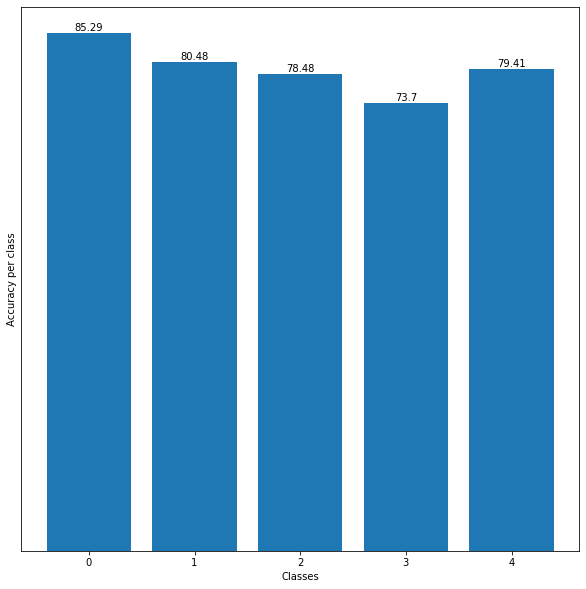

In [ ]:
import matplotlib.pyplot as plt 
plt.figure(figsize = (10,10)) 
plt.bar(x,y,align='center') 
plt.xlabel('Classes')
plt.ylabel('Accuracy per class') 
plt.yticks([]) 
for i in range(len(y)):
    plt.annotate(str(y[i]), xy=(x[i],y[i]), ha='center', va='bottom')
plt.show()

Allo stesso modo dei modelli precedenti, per effettaure una prova di predizione, carico il *tf-idf vectorizer* e il modello

In [ ]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
with open('tfidf_vectorizer.pk','rb') as f:
    tfidf_vectorizer = pickle.load(f)
nn = tf.keras.models.load_model('neural_network.h5')


classes = {0 : 'Anger', 1 : 'Fear',2 : 'Joy', 3 : 'Sadness',4 : 'Neutral'}


query = "Hi all"
transformed_query = tfidf_vectorizer.transform([query]).toarray()
prediction_class = nn.predict(transformed_query)
prediction = np.argmax(prediction_class, axis = 1)
print(f"Query: {query}, Sentiment: {classes[prediction[0]]}")

Query: Hi all, Sentiment: Neutral
